This notebook combines all features into one large model. 

In [1]:
model_name = "patch_tst_small" + "_model_files"

In [43]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from autogluon.common import space
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import pickle

In [3]:
module_path = os.path.abspath(os.path.join('../..', 'utils'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ml_tools import add_weekends_holidays

d:\CS\summer_project\comp47360-group8\ml_pipeline\utils


In [4]:
# Turn off GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [5]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness', 'location':'item_id', 'datetime': 'timestamp'},axis=1, inplace=True)
print(df.columns)

Index(['timestamp', 'item_id', 'busyness'], dtype='object')


In [6]:
df['day'] = df['timestamp'].dt.day_name().str.lower()
df['hour'] = df['timestamp'].dt.hour

In [7]:
df.shape

(7319643, 5)

In [8]:
df.head()

,timestamp,item_id,busyness,day,hour
0,2021-01-01,3,132,friday,0
1,2021-01-01,4,234,friday,0
2,2021-01-01,5,19,friday,0
3,2021-01-01,6,37,friday,0
4,2021-01-01,7,493,friday,0


In [9]:
df_open = pd.read_csv("../../data_preparation/taxi_location_num_businesses_open/taxi_location_num_businesses_open.csv")
df_open.rename({'location':'item_id'},axis=1, inplace=True)


In [10]:
df

,timestamp,item_id,busyness,day,hour
0,2021-01-01,3,132,friday,0
1,2021-01-01,4,234,friday,0
2,2021-01-01,5,19,friday,0
3,2021-01-01,6,37,friday,0
4,2021-01-01,7,493,friday,0
...,...,...,...,...,...
7319638,2024-04-01,107,1,monday,0
7319639,2024-04-01,163,6,monday,0
7319640,2024-04-01,225,1,monday,0
7319641,2024-04-01,226,1,monday,0


In [11]:
df = df.join(df_open.set_index(['day', 'hour', 'item_id']), on=['day', 'hour', 'item_id'])

In [12]:
df.fillna({'alcohol':0, 'food':0, 'leisure':0}, inplace=True)

In [13]:
df.drop(['day', 'hour'], axis=1, inplace=True)

In [14]:
df.head()

,timestamp,item_id,busyness,food,alcohol,leisure
0,2021-01-01,3,132,0.0,0.0,0.0
1,2021-01-01,4,234,0.0,0.0,0.0
2,2021-01-01,5,19,0.0,0.0,0.0
3,2021-01-01,6,37,0.0,0.0,0.0
4,2021-01-01,7,493,0.0,0.0,0.0


In [15]:
df_wth = pd.read_csv("../../data_evaluation/weather_meteostat/meteostat_weather.csv")
df_wth.rename({'time':'timestamp'}, axis=1,inplace=True)
df_wth['timestamp'] = df_wth['timestamp'].astype('datetime64[us]')
df_wth['timestamp'] = pd.to_datetime(df_wth['timestamp'])
df_wth['coco'] = df_wth['coco'].astype('category')
df_wth.sort_values(by=['timestamp'])
df = df.join(df_wth.set_index('timestamp'), on='timestamp', how='left')

In [16]:
static_features_df = pd.read_csv("../../data_evaluation/taxi_trip_data/taxi_zone_lookup.csv")
static_features_df.rename({'LocationID': 'item_id'}, axis=1, inplace=True)

In [17]:
df = df[df['item_id'].isin(static_features_df.loc[static_features_df['Borough']=="Manhattan", 'item_id'])]

In [50]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df = static_features_df
)
data = data.sort_index()
data = data.fill_missing_values()

In [52]:
add_weekends_holidays(data)

In [53]:
pkl_file_path = 'patch_tst_small_df.pkl'
with open(pkl_file_path, 'wb') as f:
    pickle.dump(data, f)

In [20]:
data.head()

,,busyness,food,alcohol,leisure,temp,dwpt,rhum,prcp,pres,coco,weekend,holiday
item_id,timestamp,,,,,,,,,,,,
4,2021-01-01,234,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
12,2021-01-01,2,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
13,2021-01-01,79,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
24,2021-01-01,123,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
41,2021-01-01,462,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0


In [21]:
prediction_length = 4 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [24]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    quantile_levels=[0.5],
    eval_metric="MASE",
    prediction_length=prediction_length,
    path=model_name,
    known_covariates_names=['food', 'alcohol', 'leisure', 'weekend', 'holiday', 'temp', 'dwpt', 'rhum', 'prcp', 'pres', 'coco']
)
print('we made the predictor')

we made the predictor


In [25]:
predictions = predictor.fit(test_data,
                                hyperparameters= {"PatchTST": {
                                    # "context_length":192,
                                    # "num_encoder_layers":4,
                                    # "batch_size": 1024,
                                    # "batches_per_epoch": 400
                                }},
                                refit_full=True
                                # excluded_model_types=["Chronos", "RecursiveTabular", "NPTS", "DeepAR", "AutoARIMA", "AutoETS", "DirectTabular", "DeepAR"]
                                
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'patch_tst_small_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          0
Memory Avail:       5.61 GB / 15.90 GB (35.3%)
Disk Space Avail:   2079.57 GB / 2794.50 GB (74.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'PatchTST': {}},
 'known_covariates_names': ['food',
                            'alcohol',
                            'leisure',
                            'weekend',
                            'holiday',
                            'temp',
                            'dwpt',
                            'rhum',
                            'prcp',
                            'pres',
                            'coco'],
 'num_val_windows': 1,
 'prediction_leng

In [26]:
predictor = TimeSeriesPredictor.load(model_name)

Loading predictor from path patch_tst_small_model_files


In [27]:
print(predictor.leaderboard())

           model  score_val  pred_time_val  fit_time_marginal  fit_order
0       PatchTST   -1.19481       5.708022        1805.503446          1
1  PatchTST_FULL        NaN            NaN        1804.121943          2


In [28]:
future_index = get_forecast_horizon_index_ts_dataframe(test_data, prediction_length=prediction_length, freq='H')
future_timestamps = future_index.get_level_values("timestamp").to_series()


c:\Users\Daniel\miniconda3\envs\comp47360_autogluon\lib\site-packages\autogluon\timeseries\utils\forecast.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [29]:
known_covariates = pd.DataFrame(index=future_index)

In [30]:
known_covariates['hour'] = future_timestamps.dt.hour.to_list()

In [31]:
known_covariates['day'] = future_timestamps.dt.day_name().str.lower().values
known_covariates['hour'] = future_timestamps.dt.hour.to_list()
known_covariates = known_covariates.join(df_open.set_index(['day', 'hour', 'item_id']), on=['day', 'hour', 'item_id'])
known_covariates = known_covariates.join(df_wth.set_index("timestamp"), on='timestamp', how='left')
add_weekends_holidays(known_covariates)

In [49]:
known_covariates.loc[4]

,hour,day,food,alcohol,leisure,temp,dwpt,rhum,prcp,pres,coco,weekend,holiday
timestamp,,,,,,,,,,,,,
2024-04-01 00:00:00,0,monday,0.0,0.0,0.0,13.3,-0.7,38.0,0.0,1014.4,3.0,0.0,0.0
2024-04-01 01:00:00,1,monday,1.0,0.0,0.0,13.3,-0.7,38.0,0.0,1014.4,3.0,0.0,0.0
2024-04-01 02:00:00,2,monday,1.0,0.0,0.0,12.8,-0.5,40.0,0.0,1014.6,3.0,0.0,0.0
2024-04-01 03:00:00,3,monday,1.0,0.0,0.0,12.0,-0.9,41.0,0.0,1016.0,3.0,0.0,0.0
2024-04-01 04:00:00,4,monday,1.0,0.0,0.0,12.2,-1.0,40.0,0.0,1015.1,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29 19:00:00,19,monday,14.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-07-29 20:00:00,20,monday,13.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-07-29 21:00:00,21,monday,11.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [33]:
predictions = predictor.predict(test_data, known_covariates=known_covariates)

print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Trying to fill missing values in an unsorted dataframe. It is highly recommended to call `ts_df.sort_index()` before calling `ts_df.fill_missing_values()`
Model not specified in predict, will default to the model with the best validation score: PatchTST_FULL


                                   mean        0.1         0.2         0.3  \
item_id timestamp                                                            
4       2024-04-01 00:00:00  167.929733  97.800896  122.965401  140.219650   
        2024-04-01 01:00:00  175.251129  64.710648  103.920158  131.163544   
        2024-04-01 02:00:00  141.984467  37.811714   74.872444  100.535454   
        2024-04-01 03:00:00   71.981850 -14.246888   16.655201   37.874706   
        2024-04-01 04:00:00   41.767597 -14.995749    5.460146   19.416859   
...                                 ...        ...         ...         ...   
103     2023-12-10 08:00:00    1.757540   0.690980    1.156627    1.407617   
        2023-12-10 09:00:00    1.896873   0.820395    1.291116    1.544315   
        2023-12-10 10:00:00    1.894361   0.620170    1.176382    1.476248   
        2023-12-10 11:00:00    2.096366   0.723428    1.302470    1.628878   
        2023-12-10 12:00:00    2.650040   0.843942    1.595338  

data with frequency 'None' has been resampled to frequency 'h'.


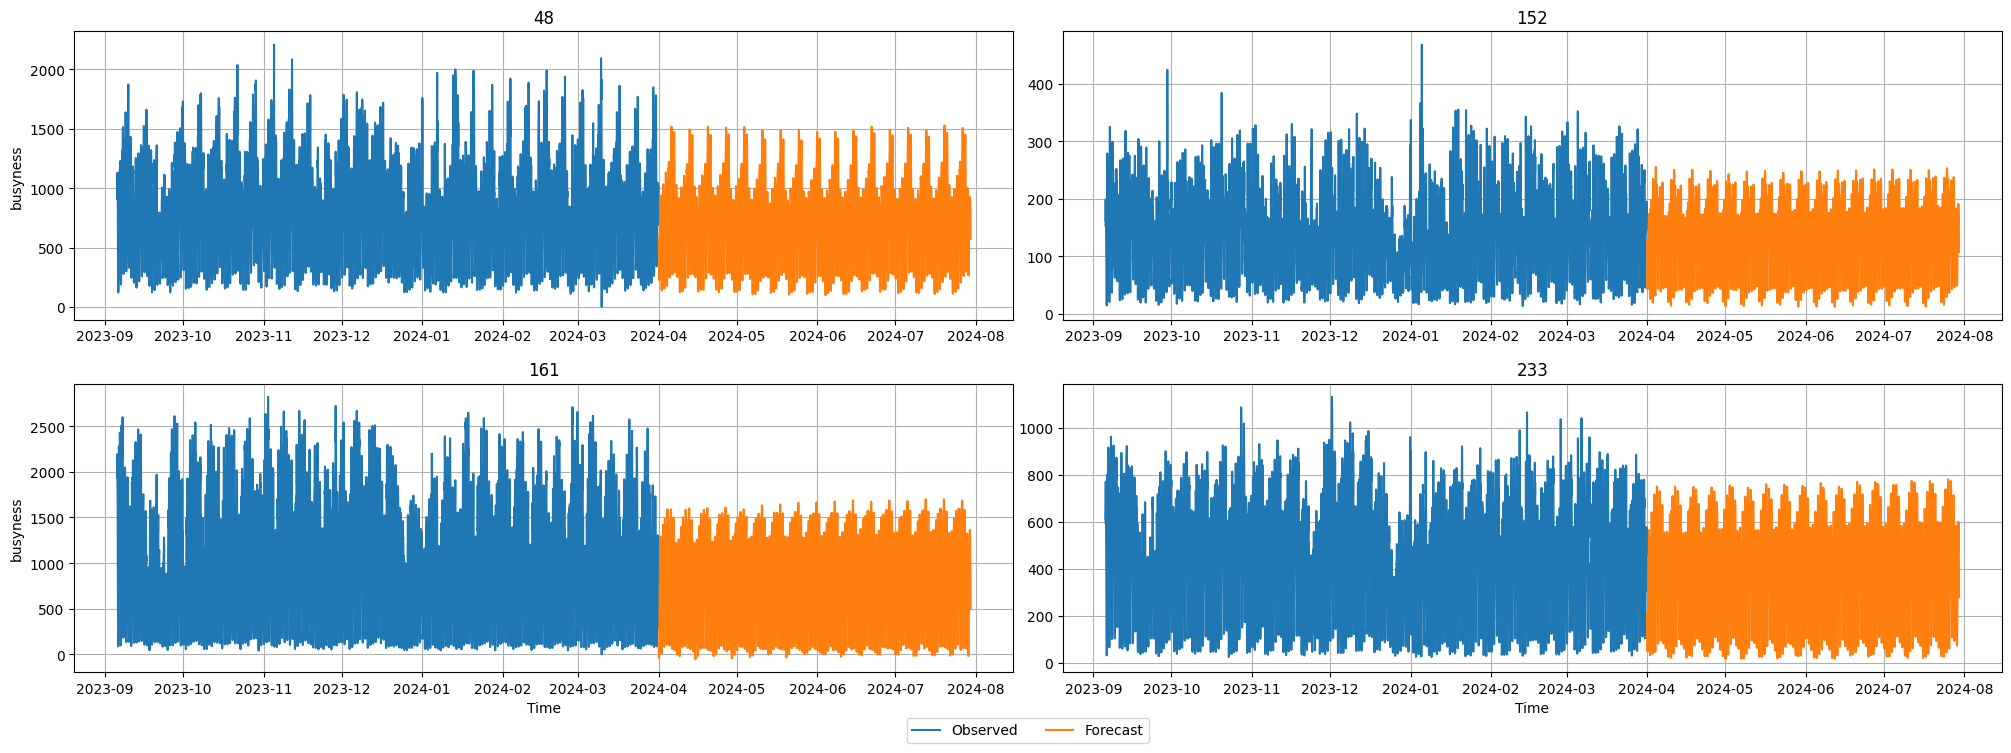

In [34]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


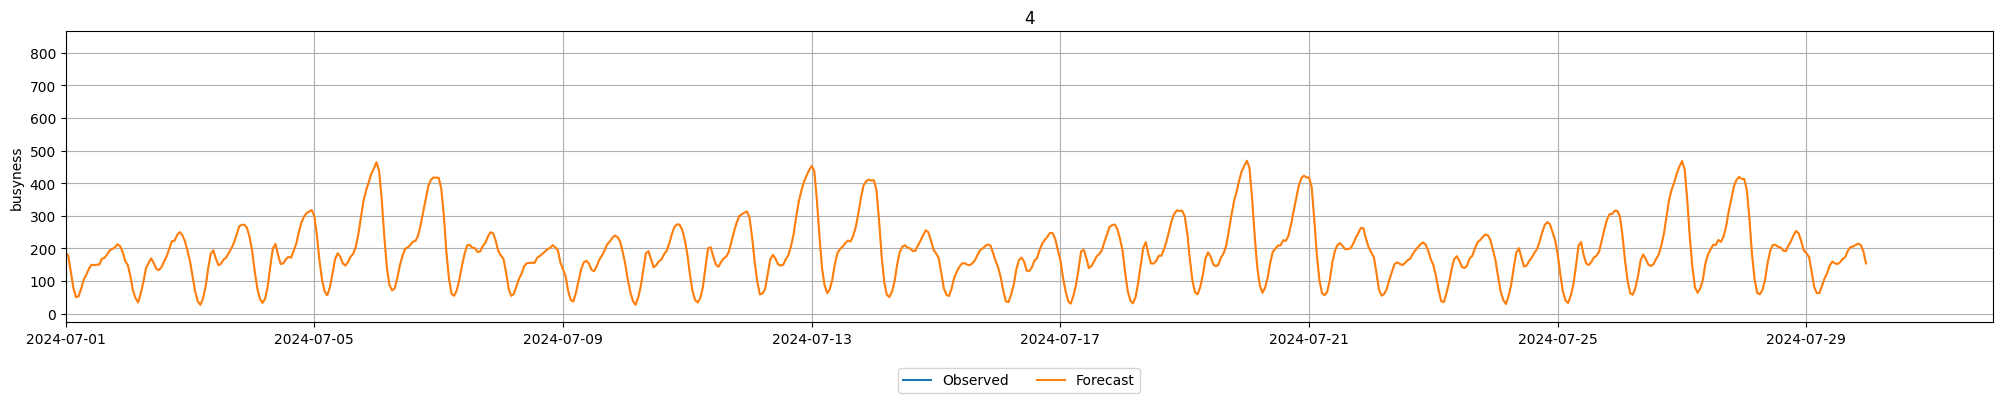

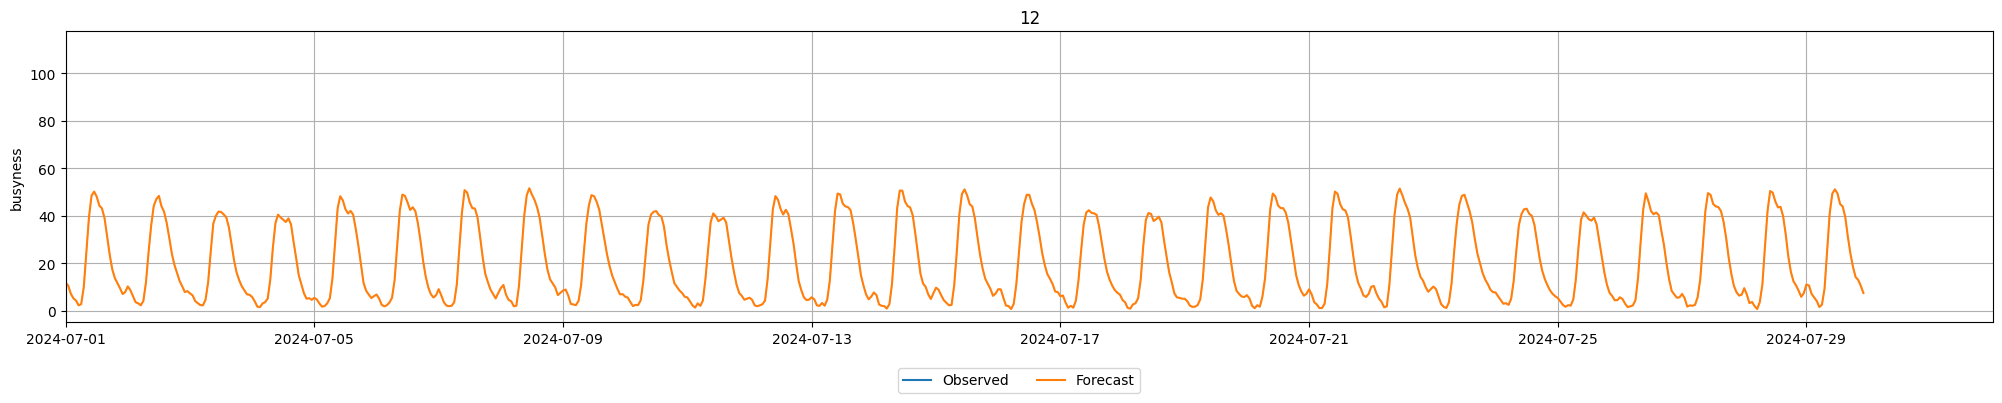

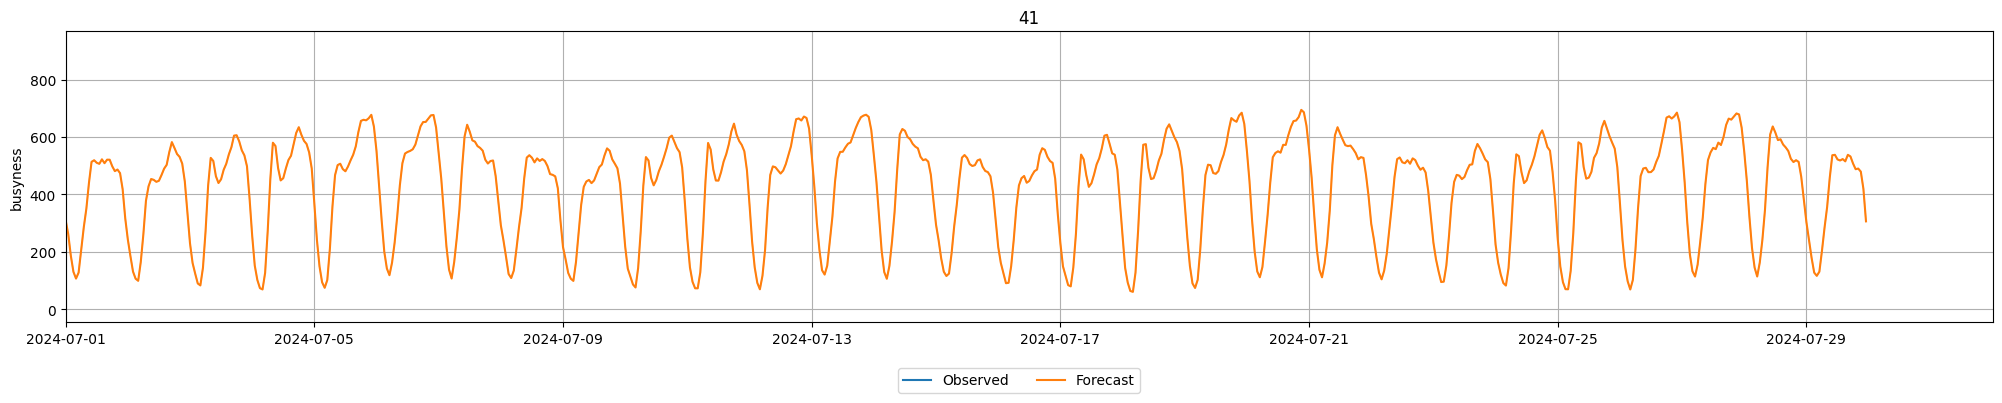

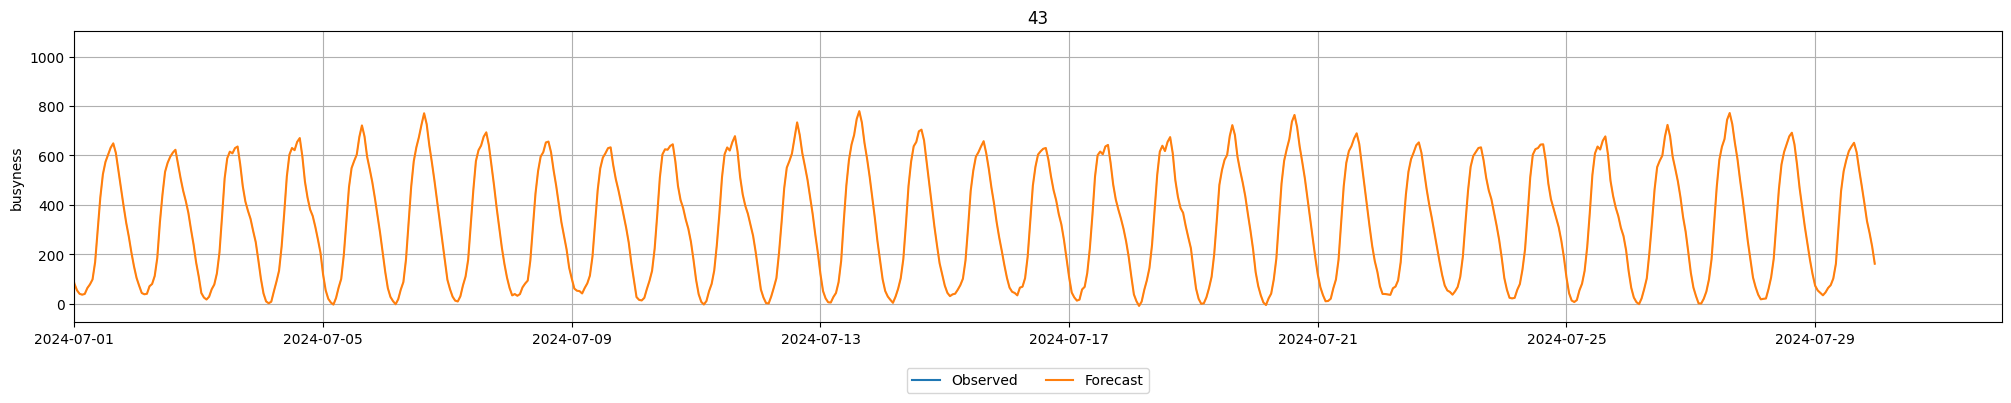

In [35]:
xmin = pd.Timestamp('2024-07-01 00:00:00')
xmax = pd.Timestamp('2024-07-31 23:59:59')
item_ids = [4, 12, 41, 43]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [36]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: PatchTST_FULL


{'MASE': -1.19284438673691}

In [42]:
# data.loc[111]

KeyError: 111